In [1]:
import warnings
import sys
sys.path.append('../src/utils')

# Core
from utils_functions import *
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
# Lectura de los subsets
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

y_train = pd.read_csv('../data/processed/y_train.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, log_loss


# K-Fold estratificado
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=25)

# Función de coste para evaluar el rendimiento del clasificador
def cost_function(X_train:pd.DataFrame, y_train:pd.Series):
    
    # Instanciamos nuestro clasificador
    model = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=4,
                                   class_weight={'<=50k': 24, '>50k': 76})
    model.fit(X_train, y_train)

    # Resultados de la validación cruzada
    scores = cross_validate(model,
                            X_train,
                            y_train,
                            scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
                            cv=skfold,
                            return_estimator=True,
                            return_train_score=True,
                            n_jobs=-1)
    
    # Rendimiento con el conjunto de train
    train_means = np.mean(scores['train_score'])
    train_std = np.std(scores['train_score'])

    # Rendimiento con el conjunto de validation
    val_means = np.mean(scores['test_score'])
    val_std = np.std(scores['test_score'])

    # Obtenemos el mejor estimador entrenado
    best_model = [estimator for idx, estimator in enumerate(scores['estimator']) if idx == np.argmax(scores['test_score'])][0]
    
    print('=== Train set ===')
    print(f'Mejor modelo de {type(best_model).__name__} con el conjunto de entrenamiento: {100*abs(train_means):0.2f}% de media +/- {100*train_std:0.2f}% de desviación estándar\n')

    print('=== Validation set ===')
    print(f'Mejor modelo de {type(best_model).__name__} con el conjunto de validación: {100*abs(val_means):0.2f}% de media +/- {100*val_std:0.2f}% de desviación estándar')

    return best_model


In [27]:
# Función de coste
model = cost_function(X_train, y_train)

=== Train set ===
Mejor modelo de RandomForestClassifier con el conjunto de entrenamiento: 47.51% de media +/- 0.13% de desviación estándar

=== Validation set ===
Mejor modelo de RandomForestClassifier con el conjunto de validación: 47.60% de media +/- 0.77% de desviación estándar


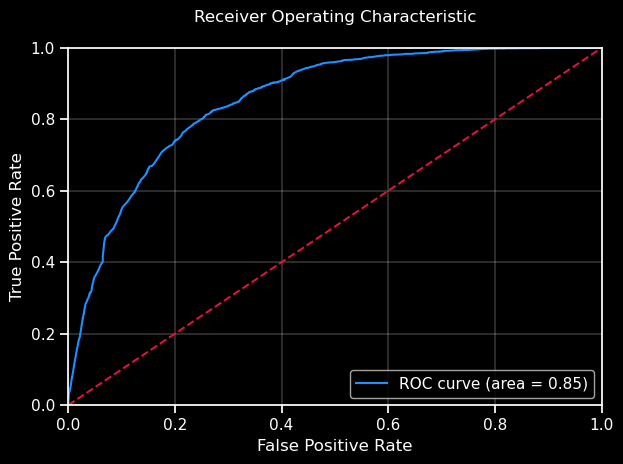

In [10]:
# Curva ROC con el modelo de línea base
roc_curve_plot(model=model, 
               X_val=X_val,
               y_val=y_val)

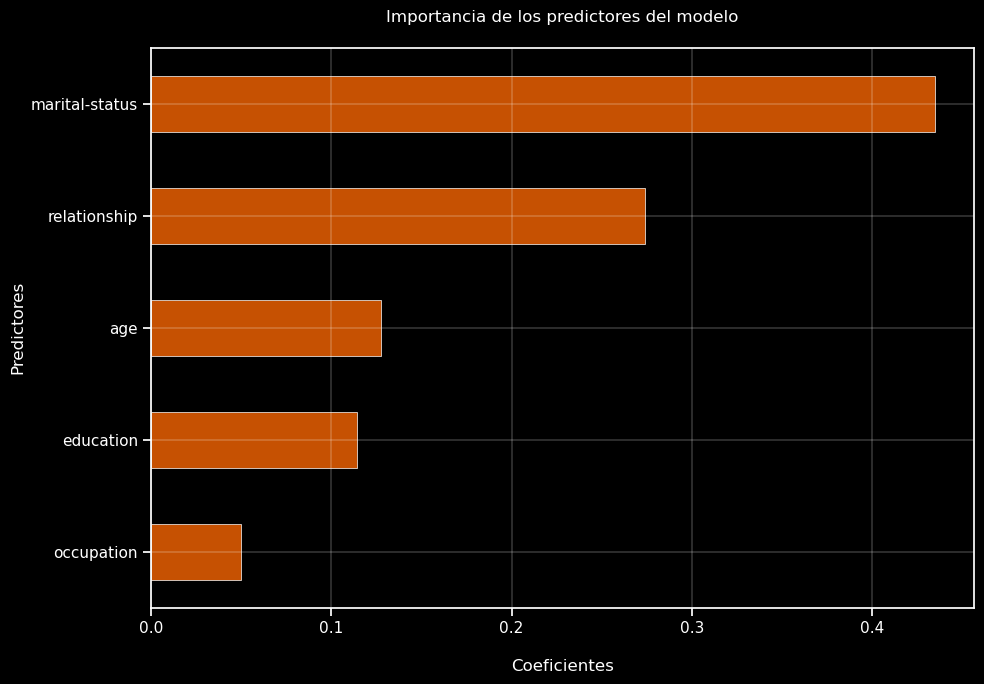

In [ ]:
# Pesos de los coeficientes
coeficientes = dict(zip(model.feature_names_in_, [predictor for predictor in model.feature_importances_]))
coef_df = pd.DataFrame.from_dict(coeficientes, orient='index', columns=['coeficientes'])

# Graficar barras horizontales
coef_df.sort_values('coeficientes', ascending=True).plot.barh(figsize=(10, 7), color='xkcd:dark orange', width=0.5,
                                                              edgecolor='white', lw=0.5, legend=False)

# Agregar etiquetas y títulos
plt.title('Importancia de los predictores del modelo\n')
plt.xlabel('\nCoeficientes')
plt.ylabel('Predictores')
plt.grid(color='white', linestyle='-', linewidth=0.25)
plt.tight_layout()

In [11]:
# Reporte de clasificación para el modelo de línea base
from sklearn.metrics import classification_report

print(classification_report(y_val, model.predict(X_val)))

              precision    recall  f1-score   support

       <=50k       0.93      0.68      0.79      7425
        >50k       0.46      0.85      0.59      2337

    accuracy                           0.72      9762
   macro avg       0.70      0.77      0.69      9762
weighted avg       0.82      0.72      0.74      9762



In [14]:
from sklearn.metrics import brier_score_loss

lb = LabelBinarizer()

# Predecir probabilidades de clase para datos de prueba
y_pred = model.predict_proba(X_val)[:, 1]

# Métricas
print(f'ROC-AUC de {type(model).__name__}: {100*log_loss(y_val, y_pred):0.2f}%')
print(f'Brier Score de {type(model).__name__}: {100*brier_score_loss(lb.fit_transform(y_val), y_pred):0.2f}%')

ROC-AUC de RandomForestClassifier: 48.78%
Brier Score de RandomForestClassifier: 16.48%


In [15]:
from sklearn.calibration import CalibratedClassifierCV
 
calibrated_model = CalibratedClassifierCV(model, cv=skfold, method='isotonic', n_jobs=-1)
calibrated_model.fit(X_val, y_val)
calibrated_probs = calibrated_model.predict_proba(X_val)[:, 1]

In [16]:
# Brier score del modelo calibrado
print(f'ROC-AUC de {type(calibrated_model.estimator).__name__}: {100*log_loss(y_val, calibrated_probs):0.2f}%')
print(f'Brier Score de {type(calibrated_model.estimator).__name__}: {100*brier_score_loss(lb.fit_transform(y_val), calibrated_probs):0.2f}%')

ROC-AUC de RandomForestClassifier: 38.25%
Brier Score de RandomForestClassifier: 12.47%


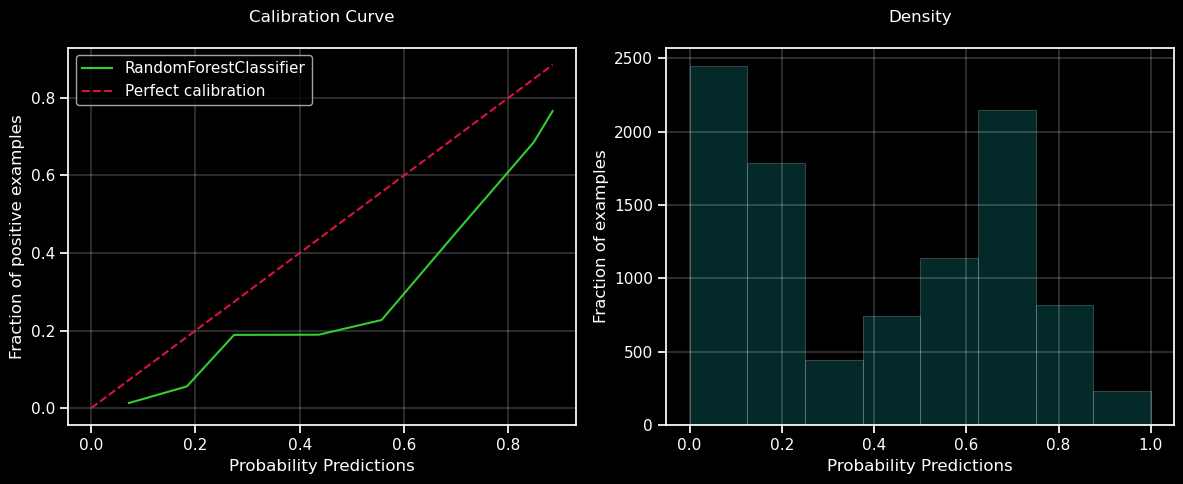

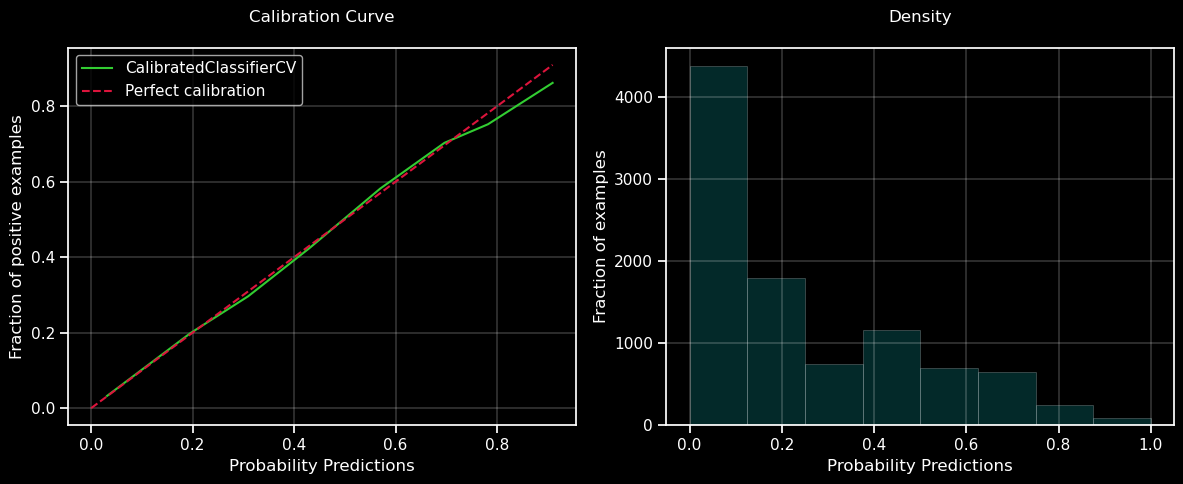

In [17]:
# A nivel visual los resultados de las comparaciones
for modelo, probs in zip([model, calibrated_model], [y_pred, calibrated_probs]):
    plot_calibration_curve(lb.fit_transform(y_val), probs, bins=8, model=modelo)

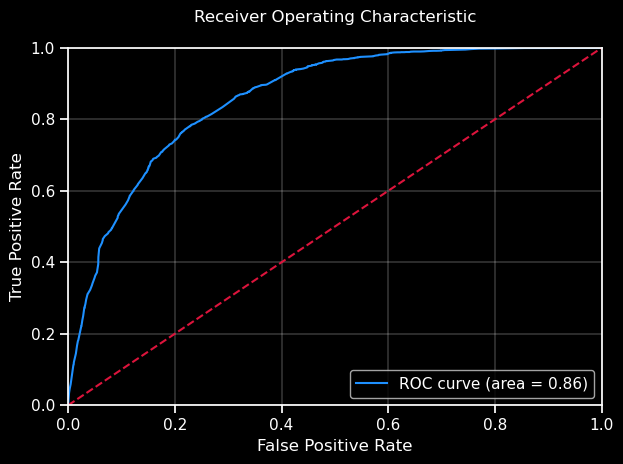

In [18]:
# Curva ROC con el modelo calibrado
roc_curve_plot(model=calibrated_model, 
               X_val=X_val,
               y_val=y_val)

In [19]:
# Reporte de clasificación del modelo calibrado
print(classification_report(y_val, calibrated_model.predict(X_val)))

              precision    recall  f1-score   support

       <=50k       0.85      0.92      0.89      7425
        >50k       0.67      0.48      0.56      2337

    accuracy                           0.82      9762
   macro avg       0.76      0.70      0.72      9762
weighted avg       0.81      0.82      0.81      9762



---
---